In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import gc

C:\Users\insuf\AppData\Local\conda\conda\envs\python352\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [18]:
import tensorflow as tf

with tf.device('/gpu:0'):
    # Creates a graph.
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    # Creates a session with log_device_placement set to True.
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [3]:
import os
os.environ

environ({'JPY_PARENT_PID': '792', 'SYSTEMDRIVE': 'C:', 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files', 'OS': 'Windows_NT', 'HOMEDRIVE': 'C:', 'HOMEPATH': '\\Users\\insuf', 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files', 'PAGER': 'cat', '%PATH%': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v8.0\\bin', 'PROMPT': '(Python3) $P$G', 'NVTOOLSEXT_PATH': 'C:\\Program Files\\NVIDIA Corporation\\NvToolsExt\\', 'LOCALAPPDATA': 'C:\\Users\\insuf\\AppData\\Local', 'IPY_INTERRUPT_EVENT': '1680', 'ONEDRIVE': 'C:\\Users\\insuf\\OneDrive', 'PROGRAMW6432': 'C:\\Program Files', 'TERM': 'xterm-color', 'CUDA_PATH_V8_0': 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v8.0', 'CONDA_ROOT': 'C:\\Users\\insuf\\Anaconda3', 'PATH': 'C:\\Users\\insuf\\Anaconda3\\envs\\Python3;C:\\Users\\insuf\\Anaconda3\\envs\\Python3\\Library\\mingw-w64\\bin;C:\\Users\\insuf\\Anaconda3\\envs\\Python3\\Library\\usr\\bin;C:\\Users\\insuf\\Anaconda3\\envs\\Python3\\Library\\bin;C:\\U

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
K.tensorflow_backend._get_available_gpus()

In [4]:
# -*- coding: unicode -*-

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [6]:
x = train.iloc[:,2:].sum()
rowsums = train.iloc[:,2:].sum(axis=1)
train['clean'] = (rowsums == 0)
print("Total clean comments = ",train['clean'].sum())

Total clean comments =  143346


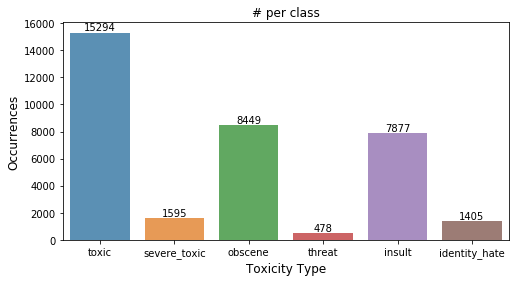

In [7]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Toxicity Type', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

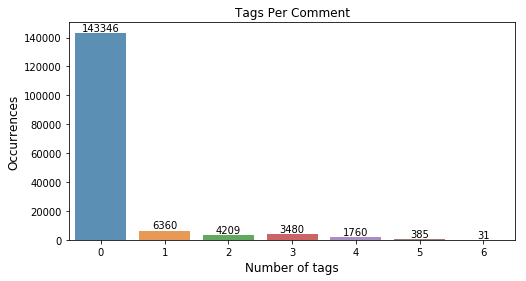

In [8]:
x = rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Tags Per Comment")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Number of tags', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [9]:
import string

df = train.iloc[:,0:2]

# Indirect features
# Word count in each comment:
df['count_word'] = df["comment_text"].apply(lambda x: len(str(x).split()))
# Unique word count
df['count_unique_word'] = df["comment_text"].apply(lambda x: len(set(str(x).split())))
# punctuation count
df["count_punctuations"] = df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# derived features
# Word count percent in each comment:
df['word_unique_percent'] = df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent'] = df['count_punctuations']*100/df['count_word']

#join the tags
train_tags = train.iloc[:,2:]
train_feats = pd.concat([df, train_tags], axis=1)

In [ ]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#spammers - comments with less than 30% unique words
spammers = train_feats[train_feats['word_unique_percent']<30]

In [ ]:
spammers

In [ ]:
# x=spammers.iloc[:,2:].sum()

In [ ]:
# x.index

In [ ]:
# plt.figure(figsize=(8,4))
# plt.title("Count of comments with low(<30%) unique words",fontsize=12)
# color = sns.color_palette()
# ax = sns.barplot(x=x.index, y=x.values,color=color[3])

# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

# plt.xlabel('Threat class', fontsize=12)
# plt.ylabel('# of comments', fontsize=12)
# plt.show()

In [ ]:
#Word count percent in each comment:
train['word_unique_percent']=train['count_unique_word']*100/train['count_word']
#derived features
#Punct percent in each comment:
train['punct_percent']=train['count_punctuations']*100/train['count_word']

# tokenizing and embedding

In [11]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [12]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
#list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [13]:
# tokenizer.word_index

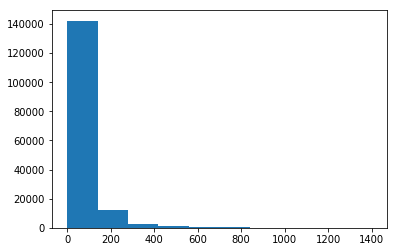

In [14]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords)
plt.show()

In [ ]:
maxlen = 200

X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
#X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
# from sklearn.utils import class_weight
# classWeight = class_weight.compute_class_weight('balanced', [[0], [1]], y)
# print(classWeight)

# Using self text embedding

In [4]:
maxlen = 200
max_features = 20000
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 120)          90720     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [ ]:
with tf.device('/gpu:0'):
    batch_size_ = 128
    epochs_ = 4
    hist = model.fit(X_t,y, batch_size=batch_size_, epochs=epochs_, validation_split=0.1)

In [ ]:
# X_test = X_te
# Y_test = test[list_classes].values
# scores = model.evaluate(X_test, Y_test)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Using Word2Vec

In [ ]:
import nltk
import gensim

# nltk.download('stopwords')
# nltk.download('punkt')

In [ ]:
description = train.comment_text.values.tolist()
stop_words = set(nltk.corpus.stopwords.words('english'))


# Function to filter stop words from tokens for each sentence
def sentence_filter(sentence_token, stop_words):
    filtered = []
    for token in sentence_token:
        if not token in stop_words:
            filtered.append(token)
    return filtered


# Input description, tokenize each sentence and return token for each sentence without stopping words
def sentence_tokenizer(description, stop_words):
    value = []
    for sentence in description:
        sentence = sentence.lower()
        tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
        sentence_token = tokenizer.tokenize(sentence)
        # sentence_token = nltk.word_tokenize(sentence)
        filtered_token = sentence_filter(sentence_token, stop_words)
        value.append(filtered_token)
    return value


# Tokenize the sentence
description_token = sentence_tokenizer(description, stop_words)

In [ ]:
# Skip gram model with minimum word count = 10 and output vector of length 300
model_sg = gensim.models.Word2Vec(description_token, window=2, min_count=10, size=300, sg=1, hs=0, negative=20, workers=4, seed=123)

# CBOW(continuous bag of words) model
# model_cbow = gensim.models.Word2Vec(description_token, min_count=10, size=300)

In [ ]:
model_sg.most_similar('niggas')

In [ ]:
model_sg.save('model_sg')

In [ ]:
# description_token

In [ ]:
model_sg = gensim.models.Word2Vec.load('model_sg')
word_vectors = model_sg.wv

embed_size = 300
embeddings_index = dict()
for word in model_sg.wv.vocab:
    embeddings_index[word] = model_sg.wv[word]
print('Loaded %s word vectors.' % len(embeddings_index))


#We get the mean and standard deviation of the embedding weights so that we could maintain the 
#same statistics for the rest of our own random generated weights. 
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()

nb_words = len(tokenizer.word_index)
#We are going to set the embedding size to the pretrained dimension as we are replicating it.
#the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

#With the newly created embedding matrix, we'll fill it up with the words that we have in both 
#our own dictionary and loaded pretrained embedding. 
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i-=1
    #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    embedding_vector = embeddings_index.get(word)
    #and store inside the embedding matrix that we will train later on.
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        embeddedCount+=1
print('total embedded:',embeddedCount,'common words')

In [ ]:
embedding_matrix.shape

In [ ]:
maxlen = 200
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

In [ ]:
batch_size = 128
epochs_ = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs_, validation_split=0.3)

# Using pre-trained embedding

In [ ]:
def loadWord2Vec():
    
    word2vecDict = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
    embed_size = 300
    
    embeddings_index = dict()
    for word in word2vecDict.wv.vocab:
        embeddings_index[word] = word2vecDict.word_vec(word)
    print('Loaded %s word vectors.' % len(embeddings_index))

    gc.collect()
    #We get the mean and standard deviation of the embedding weights so that we could maintain the 
    #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tokenizer.word_index)
    #We are going to set the embedding size to the pretrained dimension as we are replicating it.
    #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

    #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
    #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
        i-=1
        #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        #and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)
    gc.collect()

    #finally, return the embedding matrix
    return embedding_matrix

In [ ]:
embedding_matrix = loadWord2Vec()

In [ ]:
embedding_matrix.shape

In [ ]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

In [ ]:
batch_size = 32
epochs_ = 4
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs_, validation_split=0.1)

In [2]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

average_precision

0.87831705349652256